## Exploring source images

In [1]:
import cv2
import numpy as np

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Setting up image folders names
test_folder = "test_images"
calibration_folder = "camera_cal"

In [4]:
import glob
# Using glob to get list of files in folder
test_list = glob.glob(test_folder + '/*.jpg')
cal_list = glob.glob(calibration_folder + '/*.jpg')

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

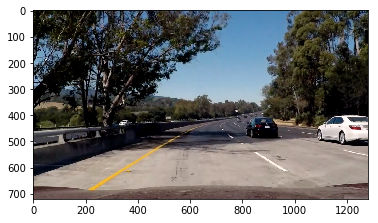

In [6]:
# Image example from test folder
lanes_image = mpimg.imread(test_list[1])
#lanes_image = mpimg.imread(test_folder + '/' + 'test1.jpg')
plt.imshow(lanes_image)

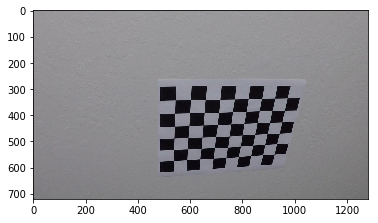

In [7]:
# Read and show distorted chessboard image from calibration folder
cb_image = mpimg.imread(cal_list[1])
plt.imshow(cb_image)

## Image processing pipeline

### Undistorting and unwarping images

In [8]:
# I've created a module named ImageProcessing, where processing functions live
# It contains thresholding, wrapping and distortion correction functions
# There is also special wrapping class for all of them, called Pipeline
import ImageProcessing as IP

Calculating distortion coefficients

In [9]:
ret, mtx, dist, rvecs, tvecs = IP.get_camera_calibration(cal_list)

In [10]:
# Helper util for drawing two images side by side, for purpose of image comparison
from utils import plot_2_images

Example of original and undistorted and unwarped calibration image

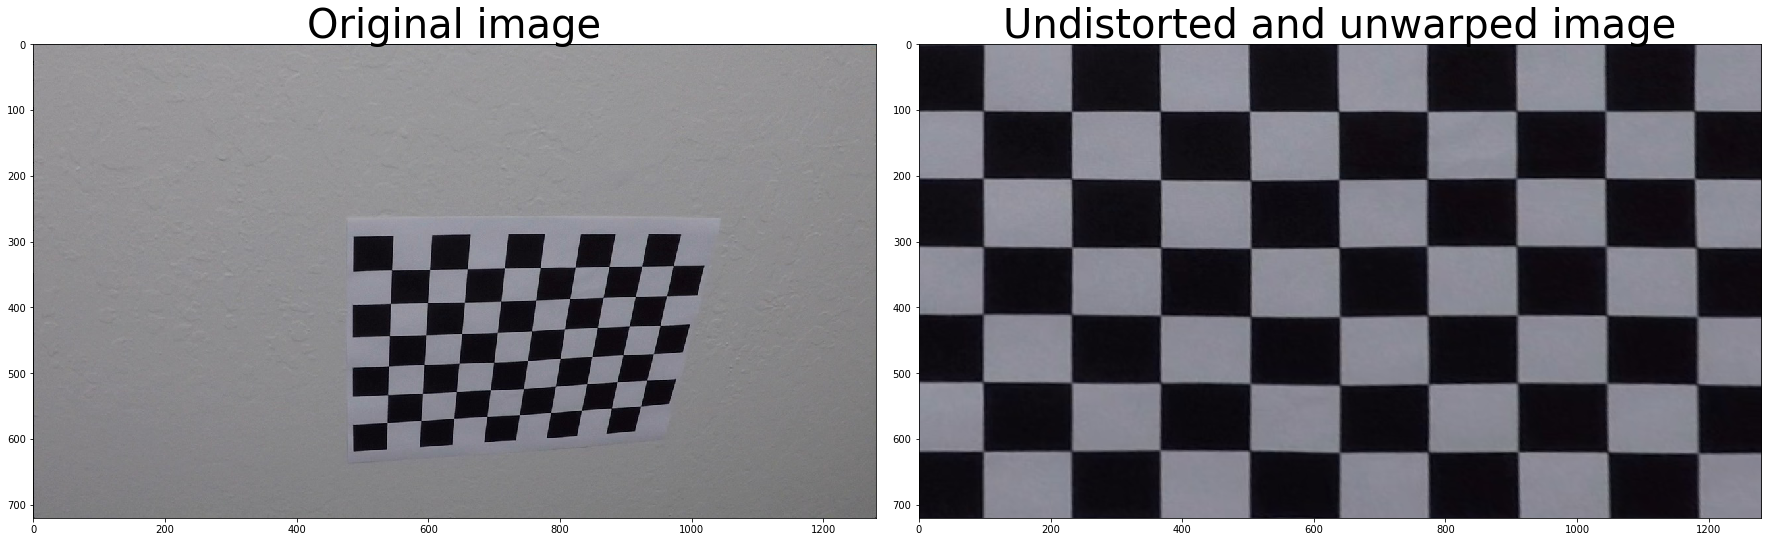

In [11]:
# Lets undistort and unwarp the image above
undist = cv2.undistort(cb_image, mtx, dist, None, mtx)
gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
offset = 100
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
if ret == True:
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0], corners[9-1], corners[-1], corners[-9]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        M_chess = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M_chess, img_size)
        plot_2_images(cb_image, warped, 'Original image', 'Undistorted and unwarped image')

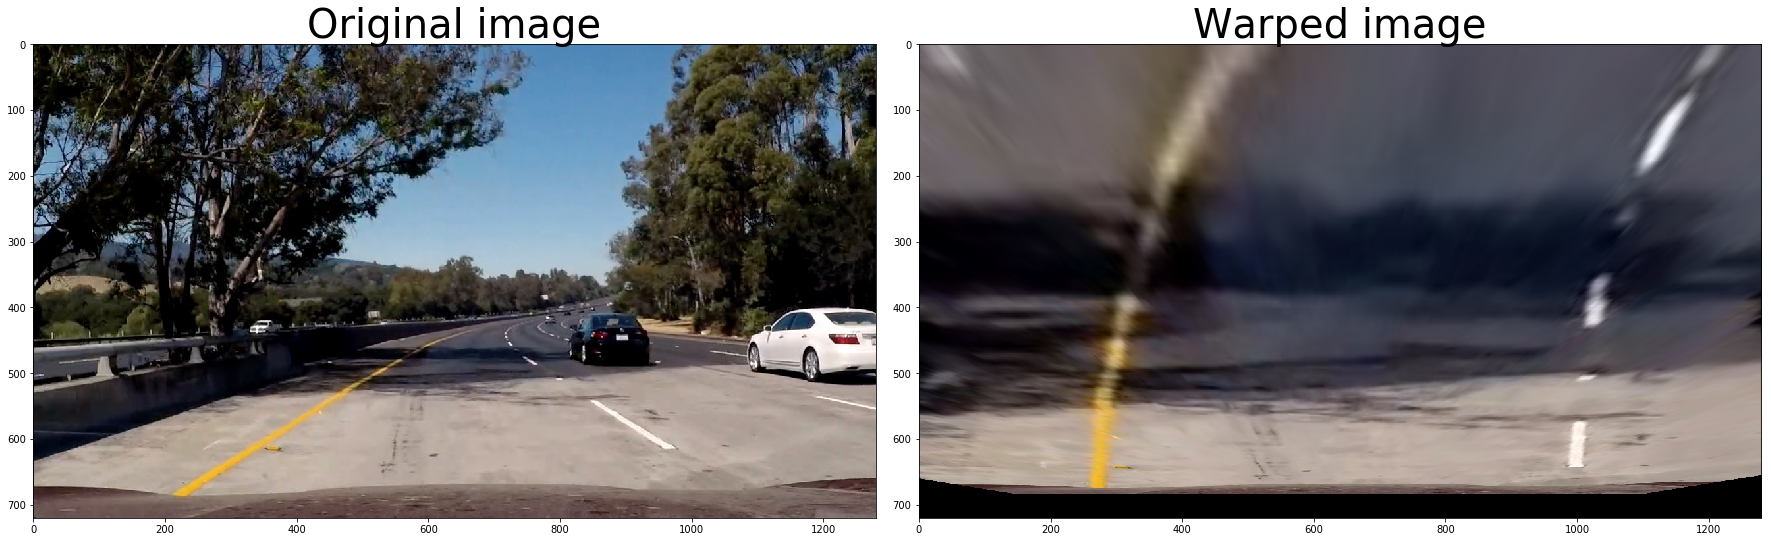

In [12]:
# Calculating perspective transormation Matrix
M, Minv = IP.get_perspective_transform_matrix()
warped_lanes = cv2.warpPerspective(lanes_image, M, (IP.IMG_SHAPE[0], IP.IMG_SHAPE[1]))
plot_2_images(lanes_image, warped_lanes, "Original image", "Warped image")

### Thresholding images

In [13]:
# Calculating thresholded Sobel binary images for X and Y axis
lanes_sob_abs_x = IP.abs_sobel_thresh(lanes_image, thresh_min=10, thresh_max=255)
lanes_sob_abs_y = IP.abs_sobel_thresh(lanes_image, thresh_min=10, thresh_max=255, orient='y')

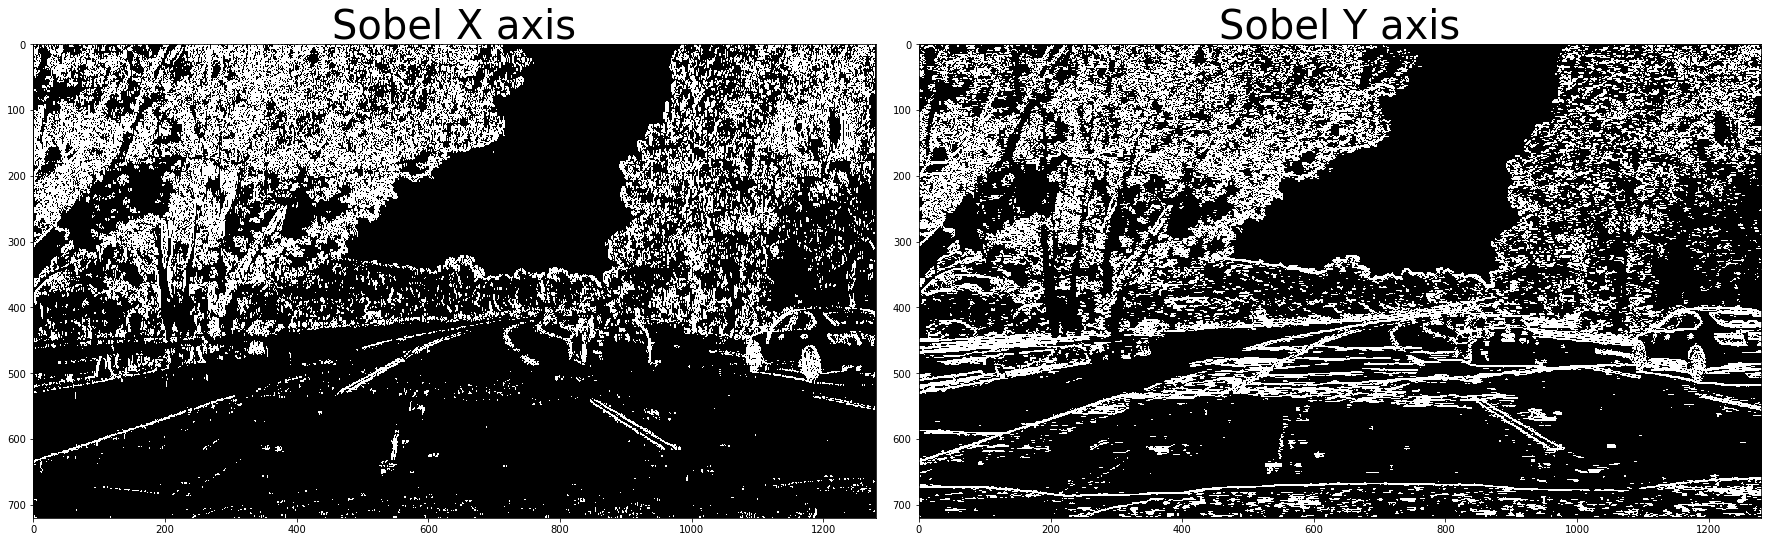

In [14]:
plot_2_images(lanes_sob_abs_x, lanes_sob_abs_y, 'Sobel X axis', 'Sobel Y axis')

In [15]:
# Calculating thresholded binary images for Sobel magnitude and direction
sobel_mag = IP.mag_thresh(lanes_image, mag_thresh=(40, 255))
sobel_dir = IP.dir_threshold(lanes_image, thresh=(np.pi/8, np.pi/3))

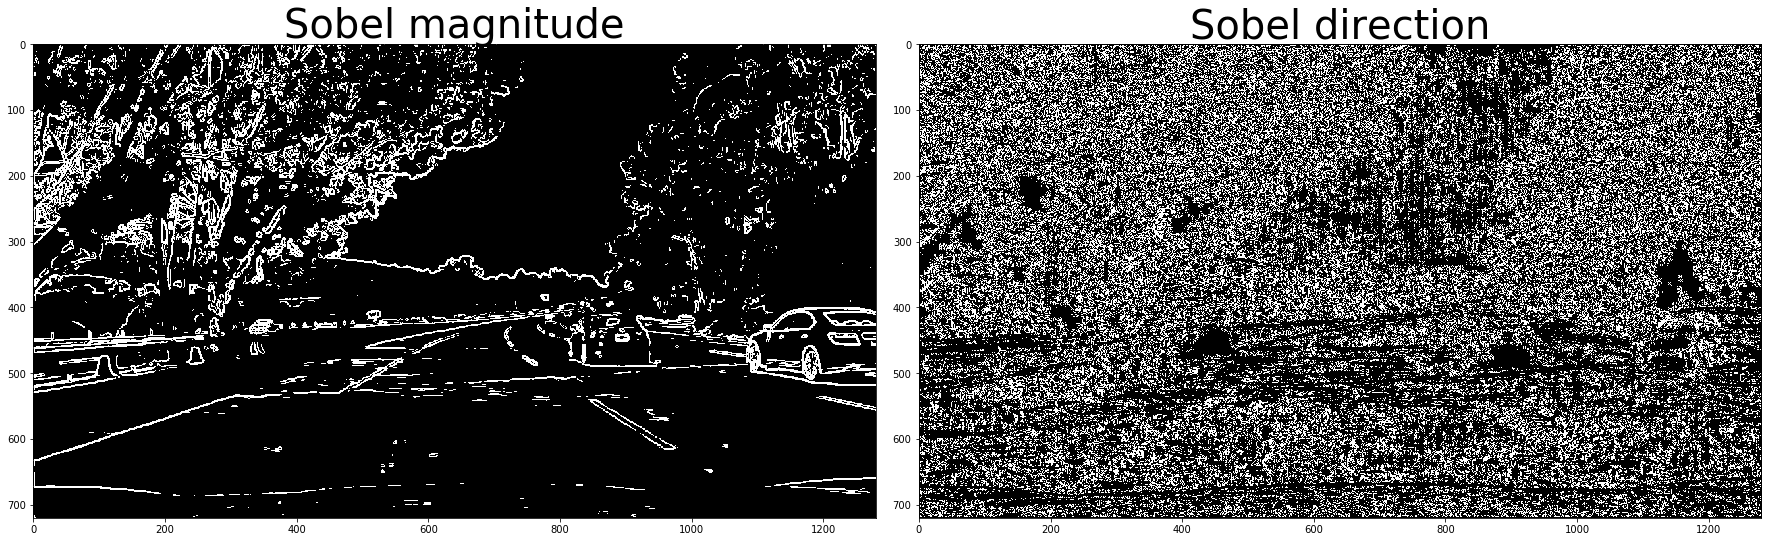

In [16]:
plot_2_images(sobel_mag, sobel_dir, 'Sobel magnitude', 'Sobel direction')

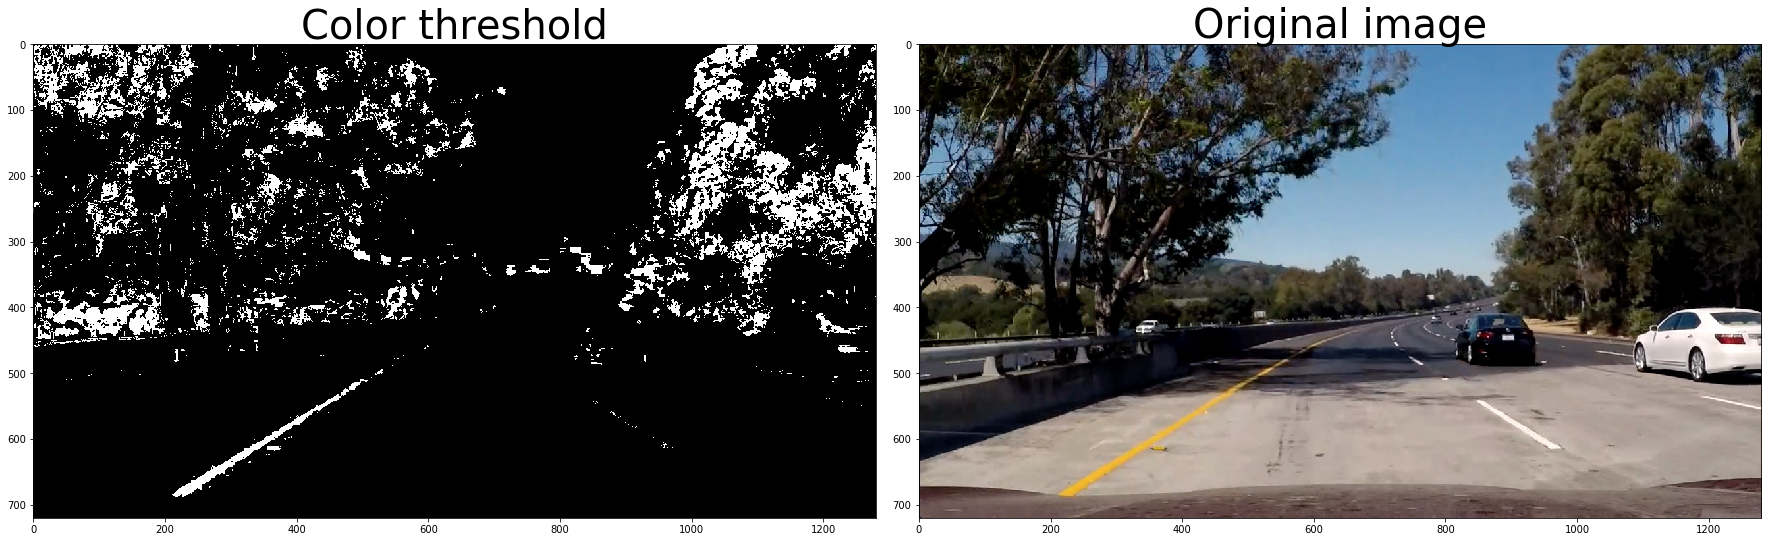

In [17]:
# Calculating threshold based on information from separate channels, after image conversion to HLS
clr_thresh = IP.color_thresh(lanes_image)
plot_2_images(clr_thresh, lanes_image, 'Color threshold', 'Original image')

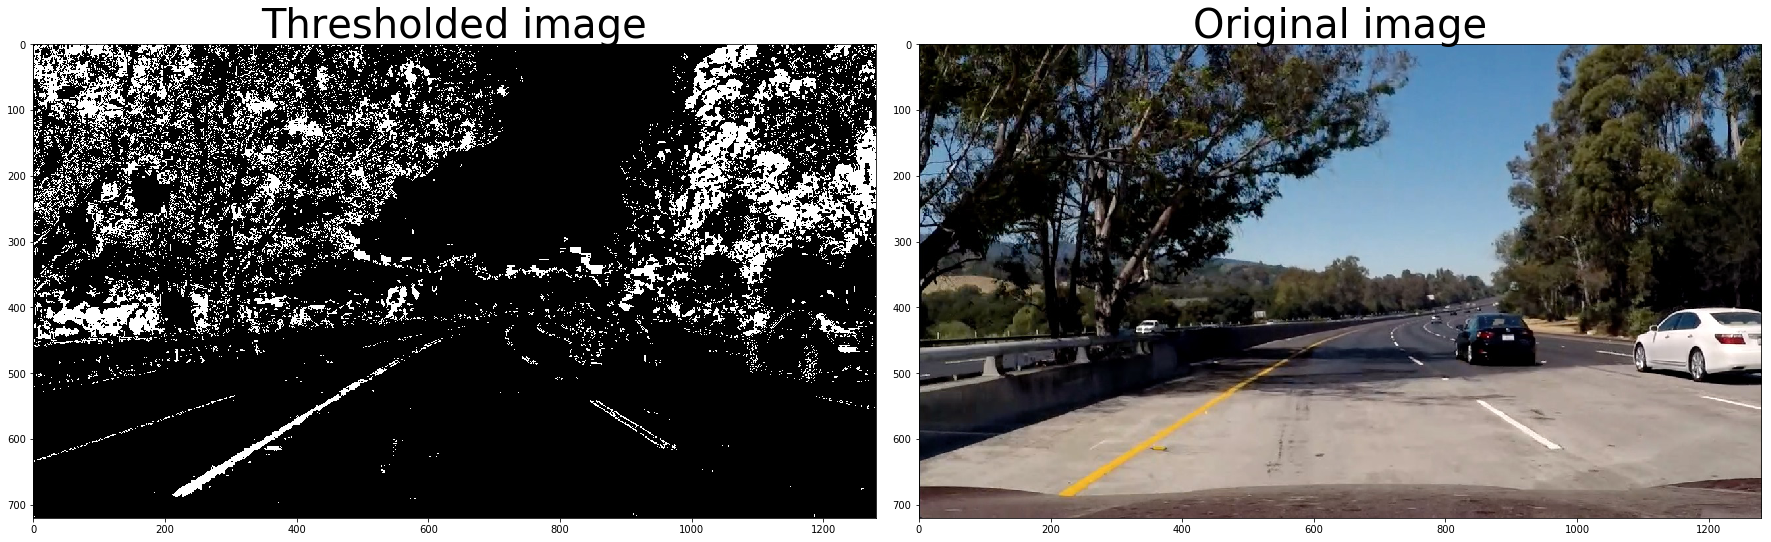

In [18]:
# Combined thresholded image
comb_lanes = IP.thresh_combined(lanes_image)
plot_2_images(comb_lanes, lanes_image, 'Thresholded image', 'Original image')

Let's see how fully processed bird's eye view image looks compared to original

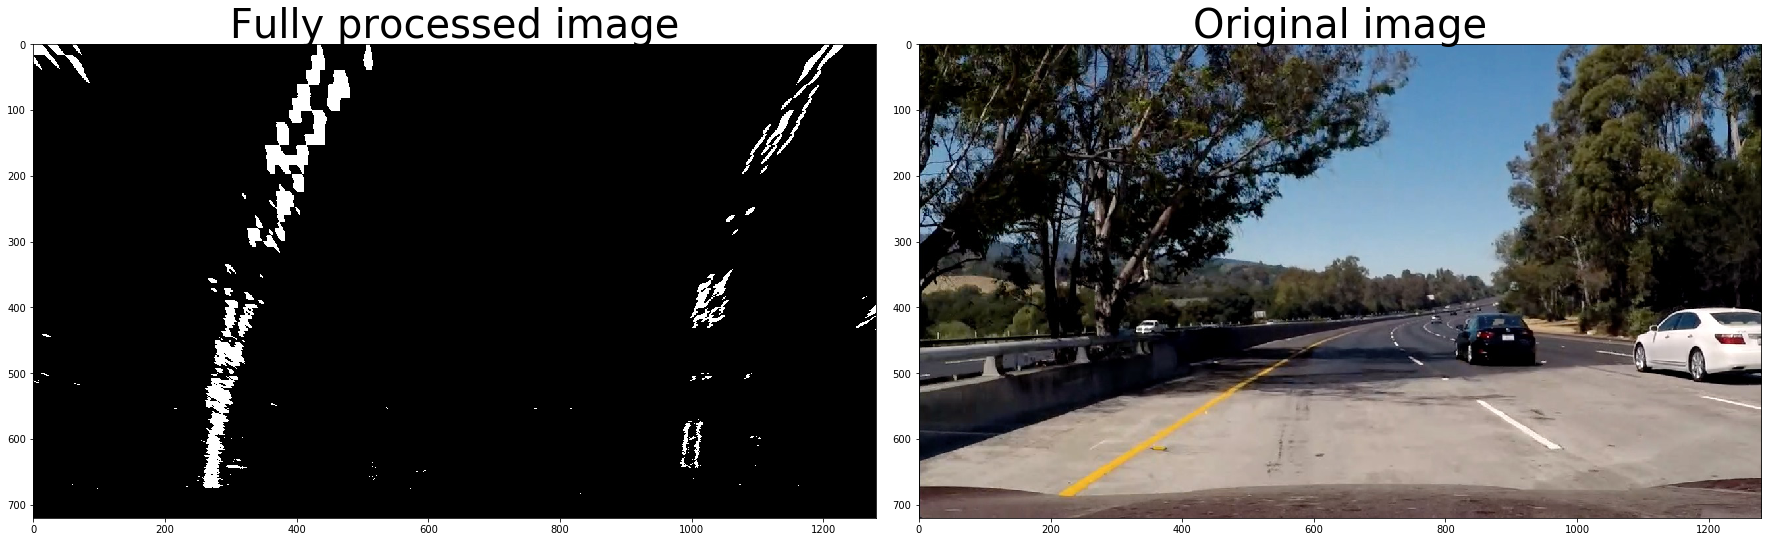

In [19]:
from ImageProcessing import Pipeline
pipe = Pipeline('camera_cal')
warped = pipe.process(lanes_image)
plot_2_images(warped, lanes_image, 'Fully processed image', 'Original image')

In [20]:
from Lane import Lane

## Lane detection and drawing lanes on an image

Basic lane detection workflow is the following:
    1. Processing a frame to get thresholded bird's eye view on a road
    2. Finding starting points for both lines, by searching peaks on a histogram
    3. Looping through an image with search windows, starting from a point, defined above
    4. If enough pixels were found on previous step - average their X coordinate and use this as starting point for next window. If the amount of pixels was low, use info from previously fitted line, to get another starting point
    5. Count total amount of pixels detected for a line. If it is above threshold - update line's parameters. If   not - draw previously fitted line. This may be not very critival, cause it is most likely the lane won't    change its curvature in a fraction of second (couple of frames)
    
More can be found as comments im Lane.py and ImageProcessing.py

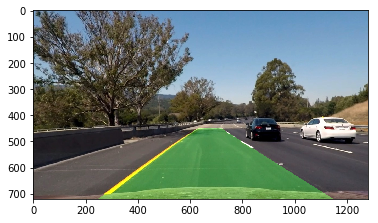

In [21]:
# Processing images from test folder and saving them to output folder
for img_name in test_list:
    image = mpimg.imread(img_name)
    lane = Lane(pipe)
    res = lane.draw_lane(image)
    plt.imshow(res)
    mpimg.imsave("output_images/" + img_name.split('/')[-1], res, cmap='gray', format='jpg')

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
# This function is used in MoviePy processing workflow. It takes a Lane object as input
# and returns other function that takes a video frame as input, draws the lane and some text over the image
def process_image(lane):
    def processor(image):
        result = lane.draw_lane(image)
        left_curvature = int(lane.left_line.radius_of_curvature)
        right_curvature = int(lane.right_line.radius_of_curvature)
        avg_curvature = (left_curvature + right_curvature)//2
        offset = lane.offset
        offset_text = "Offset is: {0} m".format(round(offset,2))
        curv_text = "Average lane curvature: " + str(avg_curvature)
        cv2.putText(result, curv_text, (30, 50), cv2.FONT_HERSHEY_PLAIN, 2.5, color=(255,255,255))
        cv2.putText(result, offset_text, (30, 100), cv2.FONT_HERSHEY_PLAIN, 2.5, color=(255,255,255))
        return result
    return processor

In [24]:
# Creating Lane object and initializing processing function
lane = Lane(pipe)
fun = process_image(lane)

In [35]:
clip = VideoFileClip("project_video.mp4")
test_clip = clip.subclip(20,25)
lane_clip = test_clip.fl_image(fun) 
%time lane_clip.write_videofile('project_video_lanes_short.mp4', audio=False)

[MoviePy] >>>> Building video project_video_lanes_short.mp4
[MoviePy] Writing video project_video_lanes_short.mp4


 99%|█████████▉| 125/126 [00:19<00:00,  5.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes_short.mp4 

CPU times: user 1min 54s, sys: 584 ms, total: 1min 54s
Wall time: 20.8 s


In [25]:
clip = VideoFileClip("project_video.mp4")
lane_clip = clip.fl_image(fun) 
%time lane_clip.write_videofile('project_video_lanes.mp4', audio=False)

[MoviePy] >>>> Building video project_video_lanes.mp4
[MoviePy] Writing video project_video_lanes.mp4


100%|█████████▉| 1260/1261 [03:19<00:00,  6.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes.mp4 

CPU times: user 18min 51s, sys: 3.74 s, total: 18min 55s
Wall time: 3min 20s
